# RAG Pipeline Demonstration
This notebook demonstrates the Retrieval-Augmented Generation (RAG) pipeline step by step, including:
1. Document Parsing
2. Chunking
3. Embedding
4. Vector Database Creation
5. Vector Search / Similarity
6. Query Demonstration





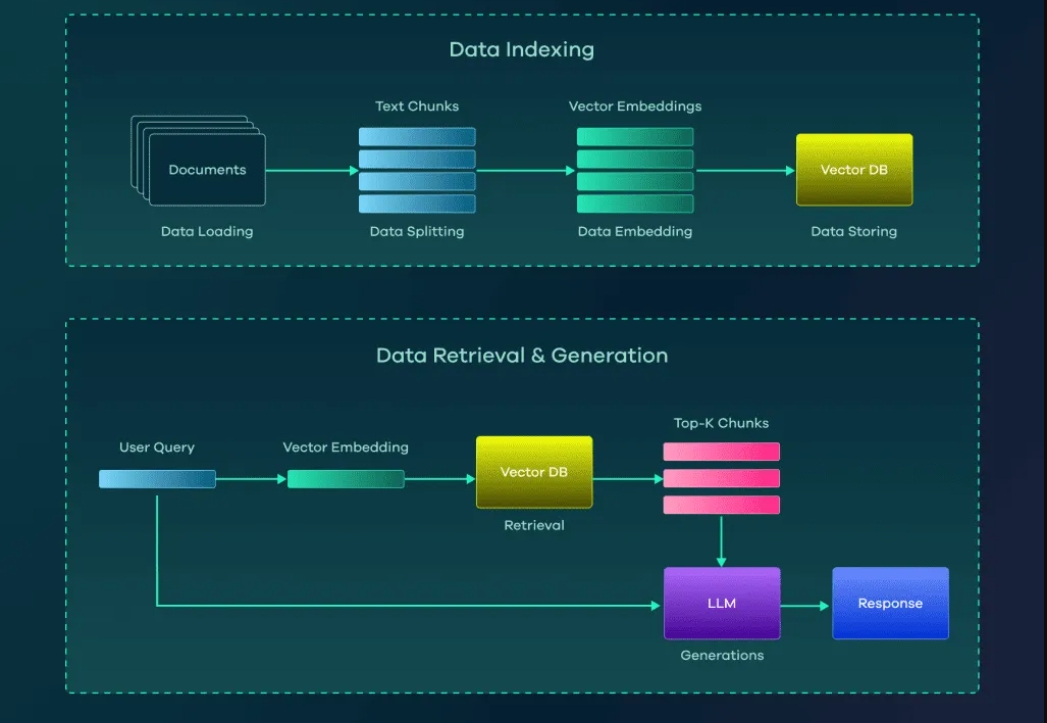

# Step 1: Document Parsing

The first step in a Retrieval-Augmented Generation (RAG) pipeline is to **load and parse the raw documents**.  
Parsing means converting different file formats (PDFs, text files, web pages, etc.) into plain text so they can be processed later.

For this demonstration, we will:
- Load text from a PDF (college notice) saved as Sample.pdf
- Parse it into a format that can be split into chunks for embeddings

In real-world RAG systems, document parsing involves:
- Extracting text from PDFs (PyPDF)
- Scraping web pages (BeautifulSoup)
- Handling DOCX/CSV, etc.


In [5]:
from pypdf import PdfReader

In [66]:
#pdf loaded
pdf_path = "sample.pdf"
reader = PdfReader(pdf_path)

print("Reader object:", reader)
print("Number of pages:", len(reader.pages))
print("Pages info:", reader.pages)

Reader object: <pypdf._reader.PdfReader object at 0x000001F6A4C619D0>
Number of pages: 4
Pages info: [PageObject(0), PageObject(1), PageObject(2), PageObject(3)]


In [73]:
#text extraction
raw_text = ""
for i, page in enumerate(reader.pages):
    page_text = page.extract_text()
    print(f"\nPage {i+1}")
    print(page_text[:100])
    raw_text += page_text + "\n"

print("\nRaw Document Loaded:")
print(raw_text[:300])
print("\nSize of raw text:", len(raw_text), "characters")


Page 1
Indian  Institute  of  Information  Technology  Raichur  
Internship  and  Placement  Policy  
 
(Ef

Page 2
○  Students  may  continue  to  avail  opportunities  for  higher  offers  until  placed  in  
Block

Page 3
 
F.  Off-Campus  Opportunities,  PPOs  &  Mandatory  Disclosures  
1.  PPOs  obtained  through  int

Page 4
academic/administrative  consequences.  
 6.  Failure  to  Disclose  Non-Acceptance  of  an  Offer  

Raw Document Loaded:
Indian  Institute  of  Information  Technology  Raichur  
Internship  and  Placement  Policy  
 
(Effective
 
from
 
October
 
2025)
 
A.  Eligibility  for  Registration  in  Career  Services  Cell  (CSC)  
1.  A  minimum  CGPA  of  5.0  (equivalent  to  50%)  with  no  active  backlog  is  required

Size of raw text: 8556 characters


In [11]:
import re

In [72]:
# multiple newlines -> single space
clean_text = re.sub(r'\n+', ' ', raw_text)

# multiple spaces -> single space
clean_text = re.sub(r'\s+', ' ', clean_text)

# leading/trailing spaces
clean_text = clean_text.strip()

print("Cleaned Document:")
print(clean_text[:300])
print("\nSize of cleaned text:", len(clean_text), "characters")

Cleaned Document:
Indian Institute of Information Technology Raichur Internship and Placement Policy (Effective from October 2025) A. Eligibility for Registration in Career Services Cell (CSC) 1. A minimum CGPA of 5.0 (equivalent to 50%) with no active backlog is required for registration in the Career Services Cell 

Size of cleaned text: 7109 characters


# Step 2: Chunking the Document

After parsing the document, the next step in the RAG pipeline is **chunking**.  

**Why chunking?**  
- Large documents cannot be directly fed into embedding models efficiently.  
- We split the text into **smaller, manageable pieces** (chunks) while optionally keeping some **overlap** to preserve context.  

**Chunking Strategy in this example:**  
- Chunk size: 100 characters  
- Overlap between chunks: 10 characters  
- Each chunk is stored in a list called **chunks**  

These chunks will be used in the next step to generate embeddings for similarity search.


In [ ]:
chunk_size = 100
overlap = 10

chunks = []

start = 0
while start < len(clean_text):
    end = start + chunk_size
    chunk = clean_text[start:end]
    chunks.append(chunk)
    start += (chunk_size - overlap)

print(f"Total Chunks Created: {len(chunks)}\n")
print("First 3 Chunks:\n")
for i, c in enumerate(chunks[:3]):
    print(f"Chunk {i+1}:\n{c}\n")

Total Chunks Created: 79

First 3 Chunks:

Chunk 1:
Indian Institute of Information Technology Raichur Internship and Placement Policy (Effective from O

Chunk 2:
ive from October 2025) A. Eligibility for Registration in Career Services Cell (CSC) 1. A minimum CG

Chunk 3:
minimum CGPA of 5.0 (equivalent to 50%) with no active backlog is required for registration in the C



# Step 3: Generating Embeddings

Once we have chunks of text, the next step is to convert them into **numeric vectors** (embeddings) using a **pretrained model**.

**Why embeddings?**  
- They capture the **semantic meaning** of text.  
- We can measure similarity between query and chunks using **vector distances**.  

**This example uses:**
- **sentence-transformers** library
- Model: **all-MiniLM-L6-v2** (lightweight, fast, good for semantic search)

These embeddings will be stored in a **vector database** in the next step.


In [ ]:
from sentence_transformers import SentenceTransformer

# pretrained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [63]:
#generate embeddings
embeddings = model.encode(chunks)

print(f"Total chunks: {len(chunks)}")
print(f"Shape of each embedding vector: {embeddings[0].shape if len(embeddings) > 0 else 'No embeddings'}")

#first 3 embeddings
import numpy as np
for i, vec in enumerate(embeddings[:3]):
    print(f"\nEmbedding for Chunk {i+1}:\n{np.round(vec[:10], 3)} ...")

Total chunks: 79
Shape of each embedding vector: (384,)

Embedding for Chunk 1:
[ 0.014  0.013  0.023  0.017 -0.021 -0.047  0.039 -0.018 -0.064 -0.017] ...

Embedding for Chunk 2:
[-0.097 -0.031  0.009 -0.019 -0.06   0.097 -0.051  0.072  0.007  0.004] ...

Embedding for Chunk 3:
[-0.019 -0.038 -0.012 -0.012 -0.069  0.039 -0.058  0.074 -0.07   0.029] ...


# Step 4: Storing Embeddings in a Vector Database

Once we have vector embeddings for each chunk, the next step is to store them in a **vector database**.  

**Why?**  
- Enables **fast similarity search**: when a user asks a question, we can quickly find the most relevant chunks.  
- Stores both **text and embeddings** for retrieval.  

**In this example:**  
- We use **ChromaDB** as our vector database.  
- Each chunk is stored with a **unique ID** and the text content.  
- Later, we will query this database to retrieve relevant chunks for a given user query.

In [36]:
import chromadb
from chromadb.utils import embedding_functions

In [ ]:
#initialize Chroma client
client = chromadb.Client()

# collection for our RAG documents
collection = client.create_collection(name="rag_doc")

# added embeddings and corresponding chunks to the collection
for i, (chunk, emb) in enumerate(zip(chunks, embeddings)):
    collection.add(
        documents=[chunk],
        embeddings=[emb.tolist()],
        ids=[f"chunk_{i}"]
    )

In [ ]:
# Get items from collection
data = collection.get()

#dict containing 'ids', 'embeddings', and 'documents'
ids = data['ids']
embeddings = data['embeddings']
documents = data['documents']

print(f"Total chunks stored: {len(ids)}\n")

for i in range(min(5, len(ids))):
    print(f"{ids[i]}\n{documents[i]}\n")

Total chunks stored: 79

chunk_0
Indian Institute of Information Technology Raichur Internship and Placement Policy (Effective from O

chunk_1
ive from October 2025) A. Eligibility for Registration in Career Services Cell (CSC) 1. A minimum CG

chunk_2
minimum CGPA of 5.0 (equivalent to 50%) with no active backlog is required for registration in the C

chunk_3
n in the Career Services Cell (CSC), in line with the graduation requirements prescribed in the Inst

chunk_4
n the Institute Ordinances. 2. Students must maintain this benchmark consistently after every semest



# Step 5: Querying the Vector Database (Retrieval)

In this step, we perform **similarity search**:

1. A user provides a **query/question**.
2. Convert the query into an **embedding vector** using the same model as before.
3. Compare the query embedding with stored chunk embeddings using **vector similarity**.
4. Retrieve the **top-k chunks** that are most relevant to the query.

**This is the "Retrieve" step in RAG** — these chunks will later be used by a language model to generate an answer.

In [49]:
query = "How are the companies classified by the CSC of IIIT Raichur?"
query_embedding = model.encode([query])[0]

# Cosine Similarity 

- Values range from **-1 to 1**:
  - 1 → vectors point in the **same direction** (very similar)  
  - 0 → vectors are **orthogonal** (no similarity)  
  - -1 → vectors point in **opposite directions** (opposite meaning)  


###  Formula
![Screenshot 2025-10-03 154930.png](<attachment:Screenshot 2025-10-03 154930.png>)
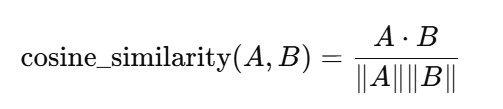

In [51]:
#similarity search in ChromaDB
results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=3
)
print(f"Query: {query}\n")
for i, doc in enumerate(results['documents'][0]):
    print(f"Top {i+1} chunk:{doc}\n")

Query: How are the companies classified by the CSC of IIIT Raichur?

Top 1 chunk:sure/ESOPs/brand value. 3. CSC reserves the right to amend the classification as per prevailing indu

Top 2 chunk:n in the Career Services Cell (CSC), in line with the graduation requirements prescribed in the Inst

Top 3 chunk:e’s on-campus process. B. Classification of Companies (for Placements) 1. There is no classification



# Step 6: Generating Answer with a Language Model (LLM)

Once we have retrieved the most relevant chunks from the vector database, the next step is to generate a **final answer** using a **Language Model (LLM)**.

**Process:**
1. Concatenate the retrieved chunks into a **context passage**.
2. Provide this context along with the **user query** to an LLM (like GPT, LLaMA, or any other model).
3. The LLM **reads the context** and generates a coherent **answer** relevant to the query.

**Note:**  
- This is the "Generate" step in **RAG** (Retrieve + Generate).  
- The quality of the answer depends on both the **retrieval step** and the **capabilities of the LLM**.


# Example 2: RAG on Website Content
We’ll use IIIT Raichur official website: https://www.iiitr.ac.in/

# Step 1: Fetching and Parsing Website Content

Instead of a PDF, we now use a **website as the data source**.  
We will extract the **visible text** from the website pages to prepare it for chunking and embedding.

- requests → fetch HTML content  
- BeautifulSoup → parse HTML and extract text


In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://www.iiitr.ac.in/"

# fetch webpage
response = requests.get(url)
html_content = response.text

# parse html
soup = BeautifulSoup(html_content, "html.parser")

# extract visible text
website_text = soup.get_text(separator="\n", strip=True)

print("Website content:")
print(website_text[:500])


Website content loaded. Sample:
Home | IIIT Raichur
Home | Indian Institute of Information Technology, Raichur
Home
About
About IIIT Raichur
Administration
Board of Governors
Finance Committee
Senate Members
Library
Reports
Campus Services
How to Reach
Press Release
Other Resources
Academics
Admission
Program
Curriculum
Calendars & Timetables
AIMS
People
Faculty
Staff
Students
Research
Research Vision
Research Areas
Publications
Sponsored Projects
Cells
Training and Placement Cell
Women Cell
Students' Welfare cell
Careers
News


# Step 2: Cleaning and Chunking the Website Text

- Remove unnecessary spaces and line breaks.  
- Split the text into **chunks of manageable size** for embeddings (e.g., 500 characters).  
- This ensures the vector database stores meaningful sections for similarity search.

In [ ]:
# Remove extra spaces and line breaks
clean_text = " ".join(website_text.split())

# Chunking function
def chunk_text(text, chunk_size=500):
    chunks = []
    for i in range(0, len(text), chunk_size):
        chunks.append(text[i:i+chunk_size])
    return chunks

#chunks
website_chunks = chunk_text(clean_text)

print(f"Total chunks created from website: {len(website_chunks)}")
print("Sample chunk:")
print(website_chunks[0])

Total chunks created from website: 6
Sample chunk:
Home | IIIT Raichur Home | Indian Institute of Information Technology, Raichur Home About About IIIT Raichur Administration Board of Governors Finance Committee Senate Members Library Reports Campus Services How to Reach Press Release Other Resources Academics Admission Program Curriculum Calendars & Timetables AIMS People Faculty Staff Students Research Research Vision Research Areas Publications Sponsored Projects Cells Training and Placement Cell Women Cell Students' Welfare cell Careers News


# Step 3: Generating Embeddings for Website Chunks

We use the same **SentenceTransformer** model (`all-MiniLM-L6-v2`) to generate **vector embeddings** for each chunk.  
These embeddings will later be stored in a **vector database** for retrieval.

In [ ]:
#embeddings for website chunks
website_embeddings = model.encode(website_chunks)

print("Embeddings generated:")
print(website_embeddings[0][:10])


Embeddings generated for website chunks. Sample embedding (first chunk):
[ 0.01143464 -0.07135183 -0.01499579  0.00328404  0.01624406 -0.03079324
 -0.01747404 -0.01043893 -0.0422477  -0.00793086]


# Step 4: Storing Website Embeddings in Vector Database

- Use **ChromaDB** to store each chunk along with its embedding and a unique ID.  
- This allows us to perform **fast similarity search** during the retrieval step.

In [ ]:
# Create a new collection for website chunks
website_collection = client.create_collection(name="iiitr_website")

# Add chunks and embeddings to the collection
for i, (chunk, emb) in enumerate(zip(website_chunks, website_embeddings)):
    website_collection.add(
        documents=[chunk],
        embeddings=[emb.tolist()],
        ids=[f"web_chunk_{i}"]
    )

print(f"Total website chunks stored in vector DB: {len(website_collection.get()['ids'])}")

Total website chunks stored in vector DB: 6
